In [1]:
import os
import tensorflow as tf

os.environ["KMP_BLOCKTIME"] = "1"
os.environ["KMP_SETTINGS"] = "1"
os.environ["KMP_AFFINITY"]= "granularity=fine,verbose,compact,1,0"
os.environ["OMP_NUM_THREADS"]= "32"
tf.config.threading.set_intra_op_parallelism_threads(32)
tf.config.threading.set_inter_op_parallelism_threads(2)

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence

import matplotlib.pyplot as plt
import numpy as np
import cv2

import os, json, shutil
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.callbacks import ModelCheckpoint, LearningRateScheduler ,EarlyStopping
from tensorflow.keras import layers
from tensorflow import keras

import os
import json
import sys

import datetime
import os
import time

from itertools import islice


train_data_dir = '/home/hgamarro/DeepLearning/HG_space/data/interim/Vegas/train'
val_data_dir = '/home/hgamarro/DeepLearning/HG_space/data/interim/Vegas/val'

out_train_data_dir = '/home/hgamarro/DeepLearning/HG_space/data/processed/Vegas/train'
out_val_data_dir = '/home/hgamarro/DeepLearning/HG_space/data/processed/Vegas/val'

In [3]:
class DataGenerator(Sequence):
    def __init__(self, list_IDs,label_map , img_dir ,mode):
        'Initialization'
        self.list_IDs = list_IDs
        self.label_map = image_label_map
        self.on_epoch_end()
        self.img_dir = img_dir + "/images"
        self.mask_dir = img_dir + "/masks"
        self.mode = mode

    def __len__(self):
        return int(len(self.list_IDs))

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))    

    
    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index:(index+1)]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        return X, y
    
    
    def __data_generation(self, list_IDs_temp):
        """Generates data containing batch_size samples"""
        if self.mode == "train":
            # Generate data
            X, y = self.load_file(list_IDs_temp)
            return X, y
        elif self.mode == "val":
            X, y = self.load_file(list_IDs_temp)
            return X, y
        
        
    def load_file(self, id_list):
        list_IDs_temp = id_list
        for ID in list_IDs_temp:
            x_file_path = os.path.join(self.img_dir, ID)
            y_file_path = os.path.join(self.mask_dir, self.label_map.get(ID))
            # Store sample
            X = np.load(x_file_path)
            # Store class
            y = np.load(y_file_path).astype('uint8')
        return X, y    

In [4]:
# ====================
# train set
# ====================
all_files = [s for s in os.listdir(out_train_data_dir + "/images/") if s.endswith('.npy')]
all_files.append([s for s in os.listdir(out_train_data_dir + "/masks/") if s.endswith('.npy')] )

image_label_map = {
        "image_file_{}.npy".format(i+1): "label_file_{}.npy".format(i+1)
        for i in range(int(len(all_files)))}
partition = [item for item in all_files if "image_file" in item]

# ====================
# validation set
# ====================

all_val_files = [s for s in os.listdir(out_val_data_dir + "/images/") if s.endswith('.npy')]
all_val_files.append([s for s in os.listdir(out_val_data_dir + "/masks/") if s.endswith('.npy')] )
val_image_label_map = {
        "image_file_{}.npy".format(i+1): "label_file_{}.npy".format(i+1)
        for i in range(int(len(all_val_files)))}
val_partition = [item for item in all_val_files if "image_file" in item]

In [5]:
train_generator = DataGenerator(partition,image_label_map,out_train_data_dir, "train")
val_generator= DataGenerator(val_partition,val_image_label_map,out_val_data_dir, "val")

In [11]:
train_generator[12][1].shape

(32, 512, 512, 1)

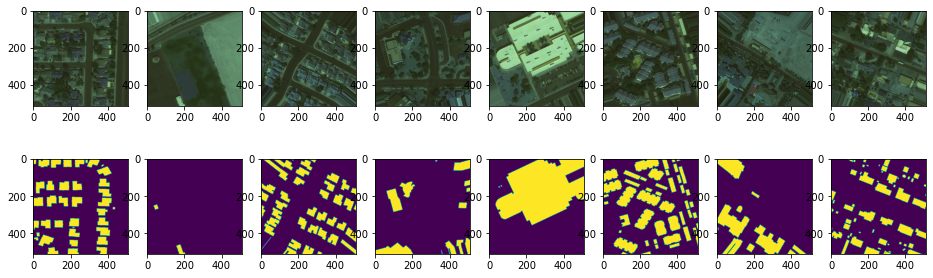

In [13]:
fig, axes = plt.subplots(2, 8, figsize=(16, 5))
# fig.subplots_adjust(hspace=0.1)

for a in np.arange(0,8):
    
    image = train_generator[30][0][a+5,:,:,:]

    # Load masks
    mask = train_generator[30][1][a+5,:,:,:]
    axes[0, a].imshow( image)
    axes[1, a].imshow( mask)

In [15]:
np.histogram(train_generator[22][0][:,:,:,:])

(array([ 811553, 8357331, 9464220, 4052924, 1593734,  542422,  193484,
         102158,   43055,    4943]),
 array([0.        , 0.09343716, 0.18687432, 0.28031147, 0.37374863,
        0.4671858 , 0.56062293, 0.6540601 , 0.74749726, 0.84093446,
        0.9343716 ], dtype=float32))

In [17]:
print(np.histogram(train_generator[14][1][:,:,:,:]))

print(train_generator[14][1][a+5,:,:,:].dtype)

(array([6346272,       0,       0,       0,       0,       0,       0,
             0,       0, 2042336]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))
uint8


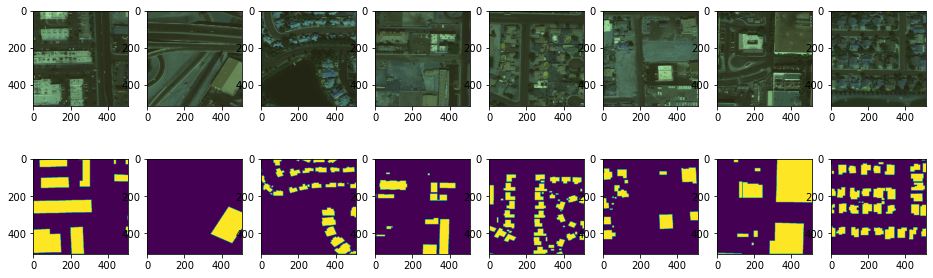

In [11]:
fig, axes = plt.subplots(2, 8, figsize=(16, 5))
# fig.subplots_adjust(hspace=0.1)

for a in np.arange(0,8):
    
    image = val_generator[5][0][a+5,:,:,:]

    # Load masks
    mask = val_generator[5][1][a+5,:,:,:]
    axes[0, a].imshow( image)
    axes[1, a].imshow( mask)

In [12]:
np.histogram(val_generator[14][0][a+5,:,:,:])

(array([  8335, 177047, 297388, 194598,  80858,  18376,   6804,   2280,
           689,     57]),
 array([0.01176471, 0.09764706, 0.1835294 , 0.26941177, 0.3552941 ,
        0.44117647, 0.52705884, 0.6129412 , 0.6988235 , 0.7847059 ,
        0.87058824], dtype=float32))

In [11]:
print(np.histogram(val_generator[14][1][a+5,:,:,:]))

print(val_generator[14][1][a+5,:,:,:].dtype)

(array([202068,      0,      0,      0,      0,      0,      0,      0,
            0,  60076]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))
uint8


In [18]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

img_size = (512, 512)
num_classes = 2

# Build model
model = get_model(img_size, 1)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

from keras import backend as K

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

In [19]:
model.compile(optimizer="rmsprop"
                 ,loss="binary_crossentropy"
                 ,metrics=["accuracy"])#,f1_m,recall_m,precision_m])

              
model_checkpoint=ModelCheckpoint(filepath ='/home/hgamarro/DeepLearning/HG_space/notebooks/random/model_4_checkpoint_unet1_e{epoch:02d}.h5'
                                                    ,save_freq = 'epoch'
                                                    ,verbose = 1
                                                    ,save_weights_only = False
                                                    ,save_best_only = True)
              
earlystop = EarlyStopping(monitor='accuracy'
                         ,min_delta = .01
                         ,patience=3)
                
        

In [ ]:
from datetime import datetime
start = datetime.now()

unet_history = model.fit(train_generator, epochs=15, validation_data=val_generator, use_multiprocessing=True , callbacks=[earlystop, model_checkpoint],)

end = datetime.now()
print("\nTime Taken for testing: %s" % (end-start))


Epoch 1/15
17/91 [====>.........................] - ETA: 1:01:02 - loss: 1.9140 - accuracy: 0.7292

In [18]:
model.save("../random/model_output4.h5")

In [19]:
def plot_history(history):
       
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss'] 
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc)
    plt.plot(val_acc)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.show();

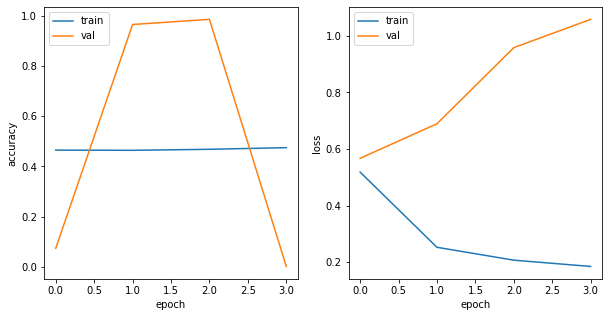

In [20]:
plot_history(unet_history)

In [112]:
unet_history.history

{'loss': [0.3397311270236969,
  0.2453213632106781,
  0.20104505121707916,
  0.17998071014881134,
  0.16745956242084503],
 'accuracy': [0.8691030740737915,
  0.9017932415008545,
  0.9192923903465271,
  0.9277315735816956,
  0.9327933192253113],
 'val_loss': [0.5726802349090576,
  0.7990082502365112,
  0.8686065077781677,
  0.8145583271980286,
  1.2351468801498413],
 'val_accuracy': [0.7974129915237427,
  0.7995733618736267,
  0.7995733618736267,
  0.7995733618736267,
  0.7995580434799194]}

In [21]:
val_check =  model.predict(val_generator[1][0])

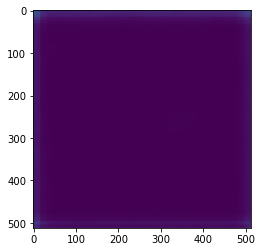

In [28]:
plt.imshow(val_check[12,:,:,0])


In [ ]:
val_generator[1][0][a + 5 , :,:,:]

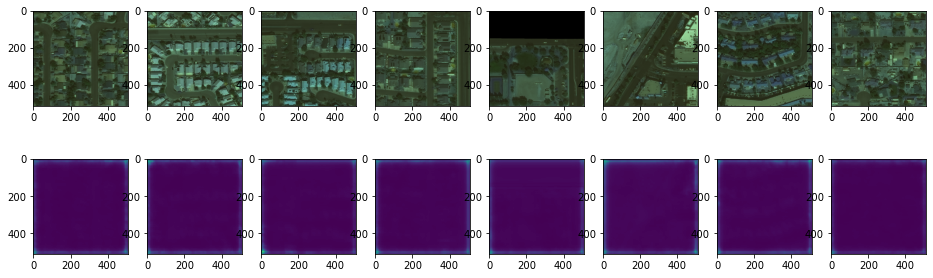

In [143]:
fig, axes = plt.subplots(2, 8, figsize=(16, 5))
# fig.subplots_adjust(hspace=0.1)

for a in np.arange(0,8):
    
    image = val_generator[1][0][a + 5 , :,:,:]

    # Load masks
    mask = val_check[a+5,:,:,:]
    
    
    axes[0, a].imshow( image)
    axes[1, a].imshow( mask)